# Importing libraries and downloading datasets

In [65]:
import torch
import random
import numpy as np
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [66]:
# уберем рандомность из вычислений
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [67]:
# get train data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

In [68]:
# split dataframe to dataframe with data and labels
y  = train[["label"]]
X = train.drop("label", axis=1)
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
y.head()

,label
0,1
1,0
2,1
3,4
4,0


In [70]:
# split data to train and test
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.15)

In [71]:
# convert data to needed format
X_train= torch.from_numpy(X_train_pd.to_numpy()).type(torch.LongTensor)
X_test= torch.from_numpy(X_test_pd.to_numpy()).type(torch.LongTensor)

y_train= torch.from_numpy(y_train_pd.to_numpy()).type(torch.LongTensor).view(-1)
y_test = torch.from_numpy(y_test_pd.to_numpy()).type(torch.LongTensor).view(-1)

In [72]:
print(X_train.shape, "\n", X_test.shape, "\n", y_train.shape, "\n", y_test.shape, "\n" )

torch.Size([35700, 784]) 
 torch.Size([6300, 784]) 
 torch.Size([35700]) 
 torch.Size([6300]) 



In [73]:
# посмотрим на тип тренировочных данных
X_train.dtype, y_train.dtype

(torch.int64, torch.int64)

In [74]:
# преобразуем  в дробный формат для вычислений производной тензора
X_train_copy = X_train.float()
X_test_copy = X_test.float()

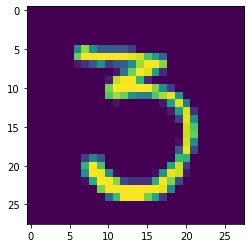

tensor(3)


In [75]:
# vizualize data
plt.imshow(X_train_copy.view(-1, 28, 28)[0, :, :])
plt.show()
print(y_train[0])

# Creating a model

## Creating fully-connected net

In [76]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        
        # inherit from a parent class
        super(MNISTNet, self).__init__()
        """ 
        create the firts level. We have 28 * 28 neurons as input because
        it's the size of a pic
        """ 
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        # create an activation function
        self.ac1 = torch.nn.Sigmoid()
        # we have 10 classes, so we have 10 neurons as the output
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    # In forward function we describe the sequence of actions
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [77]:
# check if GPU is available
torch.cuda.is_available()

True

In [78]:
# check the information about GPU
!nvidia-smi

Wed May 25 18:23:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |    645MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [79]:
# turn on GPU for calculation
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

# we can check the initial parameter of our net
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -

In [80]:
# set the loss-funct and optimizer for the net
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [81]:
%%time
batch_size = 100

# they are needed for vizualizing loss-func and accuracy plot
test_accuracy_history = []
test_loss_history = []

# turn on GPU for calculation
X_test_copy = X_test_copy.to(device)
y_test = y_test.to(device)

for epoch in range(250):
    # shuffle our data
    order = np.random.permutation(len(X_train_copy))
    
    for start_index in range(0, len(X_train_copy), batch_size):
        
        # we need to make our gradient null after each iteration. Otherwise they'll be summing.
        optimizer.zero_grad()
        
        # get needed indexes for a batch
        batch_indexes = order[start_index:start_index+batch_size]
        
        # leave the data with needed indexes
        X_batch = X_train_copy[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        
        # get the derivitive(gradient)
        loss_value.backward()
        
        # making gradient step - updating our parameters
        optimizer.step()

    test_preds = mnist_net.forward(X_test_copy)
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu().detach().numpy()
    test_accuracy_history.append(accuracy)
    if epoch % 100 == 0:
        print("epoch =", epoch,accuracy)

epoch = 0 0.89841264
epoch = 100 0.9511111
epoch = 200 0.95476186
CPU times: user 3min 39s, sys: 3.45 s, total: 3min 43s
Wall time: 3min 43s


In [82]:
# # save the results in order not to train model every time
# try:
#     with open('test_accuracy_history.pickle', 'rb') as f:
#         test_accuracy_history = pickle.load(f)
#     with open('test_loss_history.pickle', 'rb') as f:
#         test_loss_history = pickle.load(f)
    
# except:
#     with open("test_accuracy_history.pickle", 'wb') as f:
#         pickle.dump(test_accuracy_history, f)
#     with open("test_loss_history.pickle", 'wb') as f:
#         pickle.dump(test_loss_history, f)


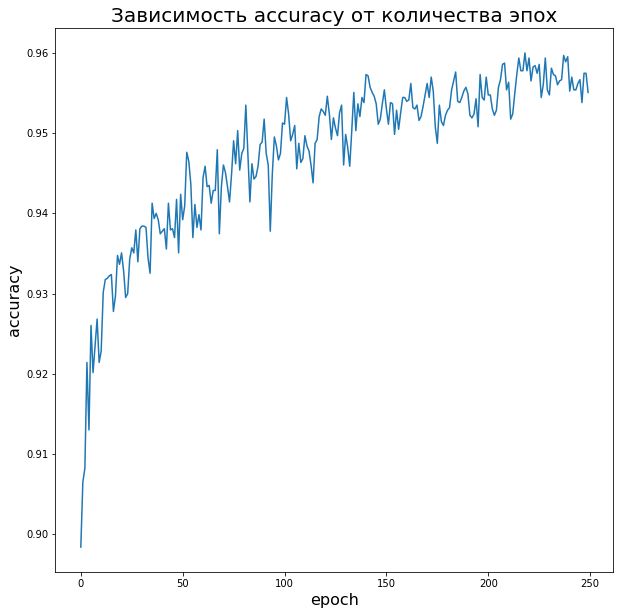

In [83]:
fig = plt.figure(figsize=(10,10))
plt.title("Зависимость accuracy от количества эпох", fontsize=20)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.plot(test_accuracy_history)


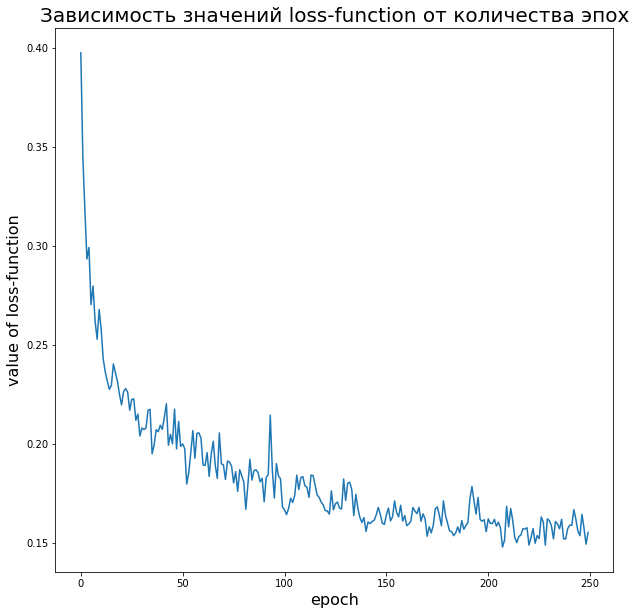

In [84]:
fig = plt.figure(figsize=(10,10))
plt.title("Зависимость значений loss-function от количества эпох", fontsize=20)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('value of loss-function', fontsize=16)
plt.plot(test_loss_history)

Get the maximum and minimum value of the metric

In [85]:
max(test_accuracy_history)

array(0.96, dtype=float32)

In [86]:
min(test_loss_history)

array(0.14768186, dtype=float32)

# Creating convolutional net

Let's see if another type of neural net performs the task better


In [87]:
# transform datasets to send them to the net
X_train_conv = X_train.view(-1, 1, 28, 28).float()
X_test_conv = X_test.view(-1, 1, 28, 28).float()

In [88]:
X_train_conv.shape

torch.Size([35700, 1, 28, 28])

In [89]:
"""
- batch-normalization should make the process of fitting a model faster;
- max-pooling should gives better results, in practice, than average-pooling;
- Tanh() as activation function leads to gradient decay. It means that in process of backpropagation the wieghts of
first layers will be not able to update, thus we have to use other act-func to avoid this.
- 2 convolutional layers with 3x3 kernel gives the same result as 1 layer with 5x5 kernel. Using 2 layers
3x3 we have to update 3x3x2=18 parameters but when using 1 layer with 5x5 we have to update 5x5=25 parameters.
For more information read about receptive field.
"""
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        # first conv layer
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = pooling_layer
        # dropout helps us to avoid overfitting
        self.dropout1 = torch.nn.Dropout(0.1)
        # first conv layer
       
        # second conv layer
        if conv_size == 5:
            self.conv2 = torch.nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5, padding=4)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = pooling_layer
        self.dropout2 = torch.nn.Dropout(0.2)
        # second conv layer

        #third conv layer
        if conv_size == 5:
            self.conv3 = torch.nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv3_1 = torch.nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, padding=1)
            self.conv3_2 = torch.nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act3 = activation_function
        self.bn3 = torch.nn.BatchNorm2d(num_features=64)
        self.dropout3 = torch.nn.Dropout(0.3)        
        #third conv layer

        # first fully-connected layer
        self.fc1 = torch.nn.Linear(5 * 5 * 64, 120)
        self.act4 = activation_function
        
        # second fully-connected layer
        self.fc2 = torch.nn.Linear(120, 84)
        self.act5 = activation_function
        
        # third fully-connected layer
        self.fc3 = torch.nn.Linear(84, 10)
        
        """
        We don't use the softmax necessarily because we can calculate loss-function and metric without it.
        It's because there are logorithm and exponent in the formulas of CrossEntropy and Softmax.
        So they can cut each other out. For more information see the folmulas)))
        """
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        # print(x.shape)
        
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        # print(x.shape)

        
        if self.conv_size == 5:
            x = self.conv3(x)
        elif self.conv_size == 3:
            x = self.conv3_2(self.conv3_1(x))
        x = self.act3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.dropout3(x)
        # print(x.shape)        


        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)
        
        return x

In [90]:
%%time
"""
To use batch-normalization correctly we have to use net.train() and net.eval(). While using batch-norm we calculate
update values of standard deviation and mean, thus we have to exclude updating those values in testing a net.
So we have to set it explicitly when we train and when we test
"""

def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(101):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        if epoch % 10 == 0:
            print("epoch =", epoch,accuracy)        
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

"""
Let's explore which model does better
"""
accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train_conv, y_train, X_test_conv, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train_conv, y_train, X_test_conv, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train_conv, y_train, X_test_conv, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train_conv, y_train, X_test_conv, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train_conv, y_train, X_test_conv, y_test)

epoch = 0 tensor(0.9133)
epoch = 10 tensor(0.9835)
epoch = 20 tensor(0.9876)
epoch = 30 tensor(0.9900)
epoch = 40 tensor(0.9878)
epoch = 50 tensor(0.9897)
epoch = 60 tensor(0.9892)
epoch = 70 tensor(0.9903)
epoch = 80 tensor(0.9905)
epoch = 90 tensor(0.9894)
epoch = 100 tensor(0.9902)
---------------
epoch = 0 tensor(0.9544)
epoch = 10 tensor(0.9905)
epoch = 20 tensor(0.9905)
epoch = 30 tensor(0.9935)
epoch = 40 tensor(0.9930)
epoch = 50 tensor(0.9933)
epoch = 60 tensor(0.9925)
epoch = 70 tensor(0.9929)
epoch = 80 tensor(0.9932)
epoch = 90 tensor(0.9919)
epoch = 100 tensor(0.9933)
---------------
epoch = 0 tensor(0.9552)
epoch = 10 tensor(0.9852)
epoch = 20 tensor(0.9916)
epoch = 30 tensor(0.9913)
epoch = 40 tensor(0.9929)
epoch = 50 tensor(0.9921)
epoch = 60 tensor(0.9933)
epoch = 70 tensor(0.9933)
epoch = 80 tensor(0.9927)
epoch = 90 tensor(0.9927)
epoch = 100 tensor(0.9935)
---------------
epoch = 0 tensor(0.9568)
epoch = 10 tensor(0.9894)
epoch = 20 tensor(0.9919)
epoch = 30 tensor

In [91]:
# # save results in order not to train model every time
# try:
#     with open('accuracies.pickle', 'rb') as f:
#         accuracies = pickle.load(f)
#     with open('losses.pickle', 'rb') as f:
#     losses = pickle.load(f)

# except:
#     with open("losses.pickle", 'wb') as f:
#         pickle.dump(losses, f)
#     with open("accuracies.pickle", 'wb') as f:
#     pickle.dump(accuracies, f)


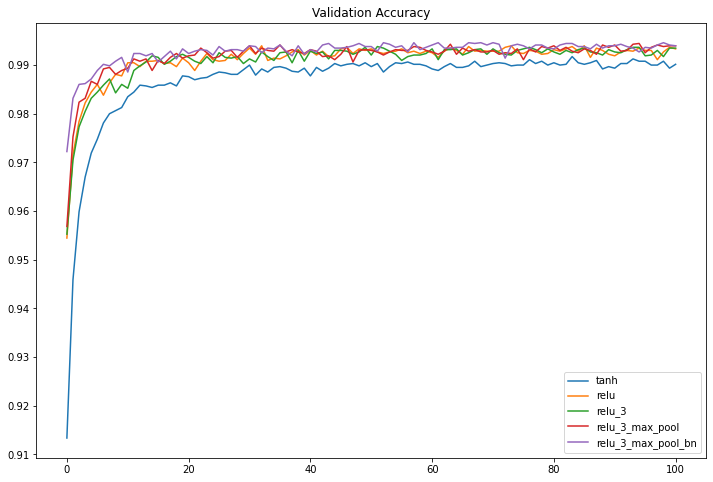

In [92]:
plt.figure(figsize=(12, 8))
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

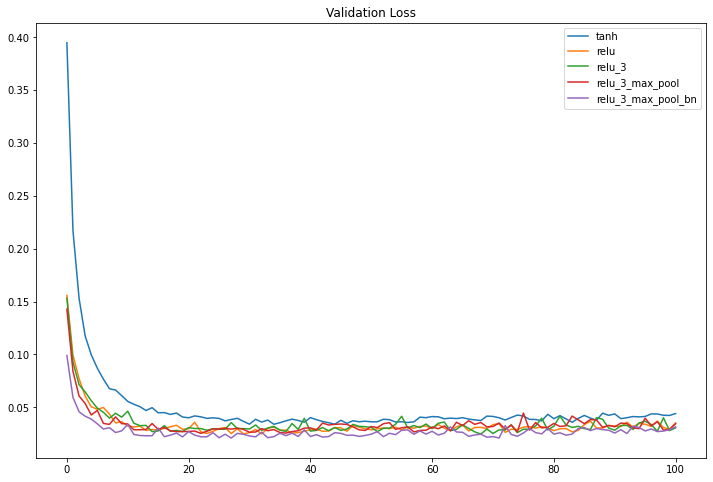

In [93]:
plt.figure(figsize=(12, 8))
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [94]:
max_value_dict = dict()
for key in accuracies.keys():
    max_value = max(accuracies.get(key))
    max_value_dict[key] = max_value
max_value

tensor(0.9946)

# Вывод

1) ***Comparing convolutional nets and fully-connected net.***

As we can see that convolutional nets perform better. The max value of fully-connected net is about 0.96 and of conv net is more than 0.99

2) ***Comparing of conv nets.***

**Looking at accuracy plot** we can see that the model with norm-batch, ReLu as act-func and 3x3 kernels with max-pooling performs better than others. Also we have proven that bath-normalization helps us to speed up the process of fitting as its graph got the high values faster than others.

**Looking at losses** plot we see that model with batch-norm has the least value of loss-func.

**Choose the model with ReLu, batch-norm and 3x3 convolutional layers**

# Making predictions by the best model

In [95]:
# for training the best net
def fit(net, X_train, y_train, num_epoch=150):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    for epoch in range(num_epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        if epoch % 20 == 0:
            print(f"num_epoch = {epoch}")


In [101]:
y_train = y_train.to(device)
# Unite all data
X_united = torch.cat([X_train_conv, X_test_conv])
y_united = torch.cat([y_train, y_test])

print(X_united.shape, "\n", y_united.shape)

torch.Size([42000, 1, 28, 28]) 
 torch.Size([42000])


In [102]:
# creating best model
best_net = LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True)

# # train the model
fit(best_net, X_united, y_united, num_epoch=200)

num_epoch = 0
num_epoch = 20
num_epoch = 40
num_epoch = 60
num_epoch = 80
num_epoch = 100
num_epoch = 120
num_epoch = 140
num_epoch = 160
num_epoch = 180


In [103]:
# with open("best_model.pickle", 'wb') as f:
#     pickle.dump(best_net, f)
# with open('best_model.pickle', 'rb') as f:
#     best_net = pickle.load(f)

In [104]:
# download test data
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# convert pd.DataFrame to torch.tensor and add some dimensions in order to transfer it to net
torch_test = torch.from_numpy(test_data.to_numpy()).type(torch.LongTensor).view(-1, 1, 28, 28).float()

In [105]:
# get predictions. argmax(dim=1) is needed to get the most likely digit among all digits for a single picture
preds = best_net.forward(torch_test.to(device)).argmax(dim=1)
preds

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [106]:
# convert tensor to np.array
pred_np = preds.cpu().detach().numpy()

# create empty DataFrame
submission_df = pd.DataFrame()

# create list of ImageId which shoud be sutable for Kagle
image_id = [i for i in range(1, 28001)]

submission_df['ImageId'] = image_id
submission_df['Label'] = pred_np

submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [107]:
submission_df.to_csv('submission.csv', index = False)

In [108]:
pd.read_csv("submission.csv").head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


# Ideas about improvement
To get better result we should choose the nets with other sturctures like AlexNet, VGG,GoogLeNet or ResNet. They are more advanced and allow us to have more layers without decaying of gradient.